In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
import torchtext.transforms as T
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import gensim.downloader
import sys 
sys.path.append('..')
from data.loadData import MovieReviews

In [2]:
# setting hyperparameters
batch_size = 32
valid_size=0.3 # validation + testing
test_size=0.5 # tesing / (testing+validation)
learning_rate = 0.001
weight_decay = 0.0005
dropout = 0.5
epoch = 10
seed = 42
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

tokenizer = get_tokenizer("basic_english")
glove_vectors = gensim.downloader.load('glove-twitter-25')
unknown_vector = torch.randn(glove_vectors.vector_size)
max_length = 40
embed_dim = 25
label_size = 2
min_frequency = 5
unk_token = '<unk>'
bos_token = '<bos>'
eos_token = '<eos>'
pad_token= '<pad>'
unk_idx = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3

print(torch.__version__)
print(device)

2.1.2
cpu


In [3]:
# data loading
df = MovieReviews()
train_data, temp_data = train_test_split(df, test_size=valid_size, random_state=seed)
val_data, test_data = train_test_split(temp_data, test_size=test_size, random_state=seed)

In [4]:
vocab = build_vocab_from_iterator(
    train_data["text"].str.split(),
    min_freq=min_frequency,
    specials=[unk_token, eos_token, bos_token, pad_token],
    #  Special symbols to add. The order of supplied tokens will be preserved.
)
vocab.set_default_index(vocab[unk_token])

In [5]:
text_transform = T.Sequential(                  # chaining multiple text transformations
    T.VocabTransform(vocab),                    # convert input batch of tokens into corresponding token ids
    T.Truncate(max_length - 2),                 # Truncate input sequence
    T.AddToken(token=bos_idx, begin=True),      # Add token to beginning or end of sequence
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(),                               # Convert input to torch tensor
    T.PadTransform(max_length, padding_idx),    # Pad tensor to a fixed length with given padding value.
)

def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = tokenizer(text)
        text = text_transform(text) # shape: [max_len, embed_dim]
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [6]:
# DataLoader
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False           #　don't shuffle to check answer with original data
)
val_iter = DataLoader(
    val_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

In [7]:
vocab_to_index = vocab.get_stoi()
vocab_size = len(vocab_to_index)
embeds = torch.randn(vocab_size, embed_dim)

for word, index in vocab_to_index.items():
    if word in glove_vectors:
        embeds[index] = torch.tensor(glove_vectors[word])

In [20]:
def generate_random_context(batchsize, seq_len, embedding_dim):

    context = torch.randn(batchsize, seq_len, embedding_dim) 
    return context

In [42]:
# model
class Attention(nn.Module):
  def __init__(self, d_model):
    super(Attention, self).__init__()
    self.score = nn.Linear(d_model, 1, bias=False)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # (batch_size, seq_len, d_model)
    scores = self.score(x)
    # (batch_size, 1, seq_len)
    weights = self.softmax(scores.transpose(1, 2))
    # (batch_size, 1, seq_len) * (batch_size, seq_len, d_model) -> (batch_size, 1, d_model)
    context = torch.bmm(weights, x) # batch matrix-matrix product
    return context

class TextClassifier(nn.Module):
  def __init__(self, embed_dim, label_size, d_model=128, dropout=0.5, weight_decay=0.0001):
    super(TextClassifier, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(embeds, freeze=False)
    self.lstm = nn.LSTM(embed_dim, d_model)
    self.attention = Attention(d_model)
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(d_model, label_size)

  def forward(self, x):
    # (batch_size, seq_len)
    x = self.embedding(x)
    x = self.dropout(x)
    # (batch_size, seq_len, embed_dim)
    x, _ = self.lstm(x)
    x = self.dropout(x)
    # (batch_size, seq_len, d_model)
    context = self.attention(x)
    # (batch_size, 1, d_model)
    output = self.fc(context.squeeze(1))
    # (batch_size, label_size)
    return output

In [43]:
model = TextClassifier(embed_dim=embed_dim, label_size=label_size, weight_decay=weight_decay, dropout=dropout).to(device)
print(torchinfo.summary(model))

Layer (type:depth-idx)                   Param #
TextClassifier                           --
├─Embedding: 1-1                         83,050
├─LSTM: 1-2                              79,360
├─Attention: 1-3                         --
│    └─Linear: 2-1                       128
│    └─Softmax: 2-2                      --
├─Dropout: 1-4                           --
├─Linear: 1-5                            258
Total params: 162,796
Trainable params: 162,796
Non-trainable params: 0


train

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [45]:
model.train()
training_loss = []
valid_loss = []
training_accuracy = []
valid_accuracy = []

for e in range(epoch):
    correct = 0 # for train_accuracy
    for text, label in tqdm(train_iter):
        optimizer.zero_grad()
        text = text.to(device)
        label = label.to(device)
        output = model(text)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        preds = torch.argmax(output, dim=1)
        correct += (preds == label).sum().item()
        
    training_accuracy.append(correct / len(train_iter.dataset))
    training_loss.append(loss.item())
    print(f'Epoch [{e+1}/{epoch}], Training_Loss: {loss.item():.4f}')

    # Validation
    num_correct = 0 # for valid_accuracy
    model.eval()
    val_loss = 0.0
    for x, y in val_iter:
        y = y.to(device)
        preds = model(x.to(device))
        loss = criterion(preds, y.long().to(device))
        val_loss += loss.item()
        num_correct += (torch.argmax(preds, dim=1) == y).sum().item()
    
    valid_accuracy.append(num_correct / len(val_iter.dataset))
    val_loss /= len(val_iter)
    valid_loss.append(val_loss)
    print(f'Validation loss: {val_loss:.4f}')

100%|██████████| 233/233 [00:04<00:00, 54.09it/s]


Epoch [1/10], Training_Loss: 0.6061
Validation loss: 0.6396


100%|██████████| 233/233 [00:03<00:00, 65.92it/s]


Epoch [2/10], Training_Loss: 0.5392
Validation loss: 0.6267


100%|██████████| 233/233 [00:03<00:00, 66.12it/s]


Epoch [3/10], Training_Loss: 0.5385
Validation loss: 0.6245


100%|██████████| 233/233 [00:03<00:00, 66.50it/s]


Epoch [4/10], Training_Loss: 0.3708
Validation loss: 0.5885


100%|██████████| 233/233 [00:03<00:00, 67.63it/s]


Epoch [5/10], Training_Loss: 0.3318
Validation loss: 0.6238


100%|██████████| 233/233 [00:03<00:00, 67.79it/s]


Epoch [6/10], Training_Loss: 0.4231
Validation loss: 0.7038


100%|██████████| 233/233 [00:03<00:00, 68.24it/s]


Epoch [7/10], Training_Loss: 0.2868
Validation loss: 0.6652


100%|██████████| 233/233 [00:03<00:00, 68.48it/s]


Epoch [8/10], Training_Loss: 0.2854
Validation loss: 0.6849


100%|██████████| 233/233 [00:03<00:00, 68.84it/s]


Epoch [9/10], Training_Loss: 0.1987
Validation loss: 0.7012


100%|██████████| 233/233 [00:03<00:00, 69.08it/s]


Epoch [10/10], Training_Loss: 0.4566
Validation loss: 0.7325


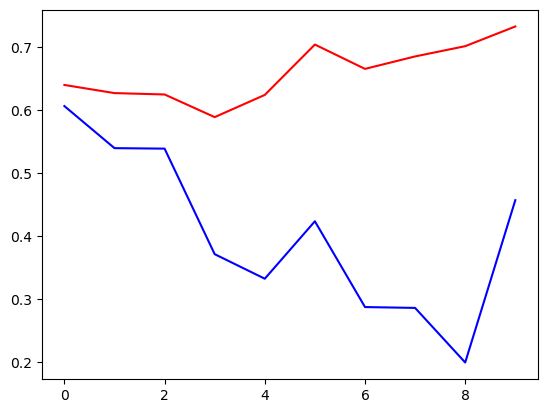

In [46]:
plt.plot(training_loss, 'b', valid_loss, 'r')

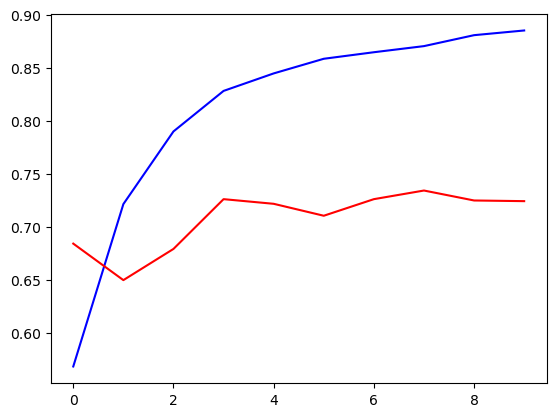

In [47]:
plt.plot(training_accuracy, 'b', valid_accuracy, 'r')

In [48]:
model.eval()
preds = []
labels = []
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(test_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text)
        pred = output.argmax(dim=1)
        labels.append(label)
        preds.append(pred)
    preds_cat = torch.cat(preds).to('cpu')
    labels_cat = torch.cat(labels).to('cpu')
    
    accuracy = accuracy_score(preds_cat, labels_cat)
    precision = precision_score(preds_cat, labels_cat)
    recall = recall_score(preds_cat, labels_cat)
    f1 = f1_score(preds_cat, labels_cat)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

100%|██████████| 50/50 [00:00<00:00, 137.14it/s]

Test Accuracy: 73.88%
Test Precision: 75.38%
Test Recall: 73.18%
Test F1 Score: 74.26%


In [49]:
# Save the model if needed
# torch.save(model.state_dict(), 'Att-BiLSTM.pth')

In [50]:
# Instantiate the model
# model = TextClassifier(vocab_size, 32, label_size, padding_idx=padding_idx)

# Load the saved state dictionary
# model_path = 'Att-BiLSTM.pth'
# model_state_dict = torch.load(model_path)

# Load the state dictionary into the model
# model.load_state_dict(model_state_dict)